# Capstone Step 8 (20.5.1): Deep Learning Prototype

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd

from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
print(f'Tensorflow Version {tf.__version__}')

Tensorflow Version 2.9.0


## Data Preparation

I built a DL prototype with a binary outcome (i.e., whether or not a patient had been readmitted for the same reason). This model was relatively disappointing (accuracy = .77, precision = .19, recall = .43). I then build a DL prototype with a multi-categorical outcome (i.e., whether or not a patient had been readmitted for the same reason or readmitted for a different reason). This model was also relatively disappointing (avg accuracy = .39, avg precision = .39, avg recall = .48). To improve model performance concerning class imbalance, I tried under-sampling, SMOTE, assigning class weights, fixing initial bias. I also revised my approach over time, simplifying the primary diagnosis variable so that each patient was assigned to their parent diagnosis category, transforming skewed continuous variables, and using string variables by preprocessing them with a TextVectorization layer in the model. I also experimented with different kernal initializers, layer architectures, optimizers, loss functions, activation functions, and numbers of epochs to optimize model performance. This third DL prototype will implement all of the above (at least in an experimental capacity) to generate the best possible model with a binary outcome. For this final DL prototype, the binary outcome will indicate whether or not a patient had been readmitted for any reason within 90 days of discharge from the hospital.

In [2]:
modeling_df = pd.read_csv(r'D:\MLE Capstone Project\Data\DL_data_prepared_multigroup.csv')

In [3]:
# Combining readmissions for the same reason with readmissions for a different reason
modeling_df['Readmit'] = np.where(modeling_df['Readmit'] == 2, 1, modeling_df['Readmit'])
modeling_df['Readmit'].value_counts()

0    538211
1     90422
Name: Readmit, dtype: int64

In [4]:
# We are going to test the code using a stratified sample of 8% of the data
# We will remove this filter once the code is working as intended
# modeling_df = modeling_df.groupby('Readmit', group_keys=False).apply(lambda x: x.sample(frac=0.08))

In [5]:
# Transforming heavily positively skewed continuous variables
modeling_df['Log_TOTCHG'] = np.log(modeling_df.pop('TOTCHG') + 1)
modeling_df['Log_N_DISC_U'] = np.log(modeling_df.pop('N_DISC_U'))
modeling_df['Log_N_HOSP_U'] = np.log(modeling_df.pop('N_HOSP_U'))
modeling_df['Log_TOTAL_DISC'] = np.log(modeling_df.pop('TOTAL_DISC'))
modeling_df['Log_LOS'] = np.log(modeling_df.pop('LOS') + 1)
modeling_df['Log_I10_NPR'] = np.log(modeling_df.pop('I10_NPR') + 1)

In [6]:
# Encoding the primary diagnosis variable
encoder = OrdinalEncoder()
feature = modeling_df.pop('Primary_dx').to_numpy().reshape(-1, 1)
Primary_dx = encoder.fit_transform(feature)
modeling_df['Primary_dx'] = Primary_dx

In [7]:
# Changing dtypes to facilitate preprocessing with Keras layers
Secondary_dx = modeling_df.pop('Secondary_dx')
Procedure = modeling_df.pop('Procedure')
MBD_dx = modeling_df.pop('MBD_dx')
modeling_df = modeling_df.astype('float64')
modeling_df['Secondary_dx'] = Secondary_dx
modeling_df['Procedure'] = Procedure
modeling_df['MBD_dx'] = MBD_dx

In [8]:
# Creating training, validation, and test sets
train, valid, test = np.split(modeling_df.sample(frac=1), [int(0.8*len(modeling_df)), int(0.9*len(modeling_df))])
print(len(train), 'Training Examples')
print(len(valid), 'Validation Examples')
print(len(test), 'Test Examples')

502906 Training Examples
62863 Validation Examples
62864 Test Examples


Given that we have imbalanced classes, and that this imbalance may have contributed to the poor performance in the prior analyses, we are going to experiment with under-sampling using the RandomUnderSampler method to lessen the class imbalance. If this method is ineffective, then it will be removed from the data preparation pipeline. The only way we can implement over-sampling (using the SMOTENC method for data with both continuous and categorical features) would be to remove the string features, so we aren't going to implement over-sampling currently.

In [9]:
# Performing SMOTE on the training data
# categorical_features = [0,3,4,5,6,8,9,11,12,13,15,16,17,18,19,27]
# y = train.pop('Readmit')
# counter = Counter(y)
# print(f'The original training data is shape {train.shape} and has {Counter(y)} samples per class.')
# oversample = SMOTENC(random_state=35, categorical_features=categorical_features, sampling_strategy=0.25)
# train_os, y_os = oversample.fit_resample(train, y)
# counter = Counter(y_os)
# print(f'The oversampled training data is shape {train_os.shape} and has {Counter(y_os)} samples per class.')

In [10]:
# Performing under-sampling on the training data
# y = train.pop('Readmit')
# counter = Counter(y)
# print(f'The original training data is shape {train.shape} and has {Counter(y)} samples per class.')
# undersample = RandomUnderSampler(random_state=35, sampling_strategy=0.33)
# train_us, y_us = undersample.fit_resample(train, y)
# counter = Counter(y_us)
# print(f'The undersampled training data is shape {train_us.shape} and has {Counter(y_us)} samples per class.')

In [11]:
# Adding the y variables back into their respective dataframes
# train['Readmit'] = y
# train_us['Readmit'] = y_us

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502906 entries, 105149 to 238917
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   APRDRG                 502906 non-null  float64
 1   APRDRG_Risk_Mortality  502906 non-null  float64
 2   APRDRG_Severity        502906 non-null  float64
 3   HOSP_BEDSIZE           502906 non-null  float64
 4   H_CONTRL               502906 non-null  float64
 5   HOSP_URCAT4            502906 non-null  float64
 6   HOSP_UR_TEACH          502906 non-null  float64
 7   AGE                    502906 non-null  float64
 8   DIED                   502906 non-null  float64
 9   DISPUNIFORM            502906 non-null  float64
 10  DMONTH                 502906 non-null  float64
 11  ELECTIVE               502906 non-null  float64
 12  FEMALE                 502906 non-null  float64
 13  HCUP_ED                502906 non-null  float64
 14  I10_NDX                502906 n

## Data Preprocessing

The remaining data preprocessing will be conducted using Keras preprocessing layers.

In [13]:
# Defining a helper function that converts pd.DataFrame objects into tf.data.Dataset objects, shuffles the data, and batches it
def dataframe_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('Readmit')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [14]:
# Checking the format of the data that the dataframe_to_dataset helper function returns
# It returns a dictionary of column names that map to column values from rows
batch_size = 5
train_ds = dataframe_to_dataset(train, batch_size=batch_size)
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of diagnoses:', train_features['Primary_dx'])
print('A batch of targets:', label_batch)

Every feature: ['APRDRG', 'APRDRG_Risk_Mortality', 'APRDRG_Severity', 'HOSP_BEDSIZE', 'H_CONTRL', 'HOSP_URCAT4', 'HOSP_UR_TEACH', 'AGE', 'DIED', 'DISPUNIFORM', 'DMONTH', 'ELECTIVE', 'FEMALE', 'HCUP_ED', 'I10_NDX', 'PAY1', 'PL_NCHS', 'REHABTRANSFER', 'RESIDENT', 'SAMEDAYEVENT', 'ZIPINC_QRTL', 'Readmit', 'Log_TOTCHG', 'Log_N_DISC_U', 'Log_N_HOSP_U', 'Log_TOTAL_DISC', 'Log_LOS', 'Log_I10_NPR', 'Primary_dx', 'Secondary_dx', 'Procedure', 'MBD_dx']
A batch of diagnoses: tf.Tensor(
[[ 2.]
 [ 0.]
 [14.]
 [14.]
 [ 0.]], shape=(5, 1), dtype=float64)
A batch of targets: tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float64)


In [15]:
# Defining a utility function to apply feature-wise normalization to continuous features
def get_normalization_layer(name, dataset):
  normalizer = layers.Normalization(axis=None)
  feature_ds = dataset.map(lambda x, y: x[name])
  normalizer.adapt(feature_ds)
  return normalizer

In [16]:
# Testing the get_normalization_layer utility function
# This returns a Tensor layer with normalized values
LOS_col = train_features['Log_LOS']
test_layer = get_normalization_layer(name='Log_LOS', dataset=train_ds)
test_layer(LOS_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.47521508],
       [-1.4211789 ],
       [-0.16773066],
       [-0.47298196],
       [ 0.29254952]], dtype=float32)>

In [17]:
# Defining a utility function to apply feature-wise multi-hot encoding to categorical features
# This function convert both strings and values to integer indices and then one hot encodes them
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)
  feature_ds = dataset.map(lambda x, y: x[name])
  index.adapt(feature_ds)
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
  return lambda feature: encoder(index(feature))

In [18]:
# Testing the get_category_encoding_layer utility function
# This returns a Tensor layer with one hot encoded values
DX_col = train_features['Primary_dx']
test_layer = get_category_encoding_layer(name='Primary_dx',dataset=train_ds,dtype='float64')
test_layer(DX_col)

<tf.Tensor: shape=(5, 25), dtype=float32, numpy=
array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [19]:
# Defining a utility function to apply feature-wise text vectorization to string variables
def get_vectorization_layer(name, dataset, output_mode='multi_hot'):
  vectorizer = layers.TextVectorization(output_mode=output_mode)
  feature_ds = dataset.map(lambda x, y: x[name])
  vectorizer.adapt(feature_ds)
  return vectorizer

In [20]:
# Testing the get_vectorization_layer utility function
# This returns a tensor layer with one hot encoded values
Procedure_col = train_features['Procedure']
test_layer = get_vectorization_layer(name='Procedure',dataset=train_ds)
test_layer(Procedure_col)

<tf.Tensor: shape=(5, 4756), dtype=float32, numpy=
array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)>

In [21]:
# Creating the data input pipeline
batch_size = 512
train_ds = dataframe_to_dataset(train, batch_size=batch_size)
valid_ds = dataframe_to_dataset(valid, shuffle=False, batch_size=batch_size)
test_ds = dataframe_to_dataset(test, shuffle=False, batch_size=batch_size)

In [22]:
# Container for processed features
all_inputs = []
encoded_features = []

In [23]:
# Continuous feature preprocessing layer
continuous_features = ['APRDRG_Risk_Mortality','APRDRG_Severity','ZIPINC_QRTL','AGE','DMONTH','I10_NDX',
                       'Log_TOTCHG','Log_N_DISC_U','Log_N_HOSP_U','Log_TOTAL_DISC','Log_LOS','Log_I10_NPR']
for header in continuous_features:
  cont_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(name=header, dataset=train_ds)
  encoded_cont_col = normalization_layer(cont_col)
  all_inputs.append(cont_col)
  encoded_features.append(encoded_cont_col)

In [24]:
# Categorical feature preprocessing layer
categorical_features = ['APRDRG','HOSP_BEDSIZE','H_CONTRL','HOSP_URCAT4','HOSP_UR_TEACH','DIED','DISPUNIFORM','ELECTIVE',
                        'FEMALE','HCUP_ED','PAY1','PL_NCHS','REHABTRANSFER','RESIDENT','SAMEDAYEVENT','Primary_dx']
for header in categorical_features:
    cat_col = tf.keras.Input(shape=(1,), name=header, dtype='float64')
    encoding_layer = get_category_encoding_layer(name=header, dataset=train_ds, dtype='float64')
    encoded_cat_col = encoding_layer(cat_col)
    all_inputs.append(cat_col)
    encoded_features.append(encoded_cat_col)

In [25]:
# Text feature preprocessing layer
text_features = ['Secondary_dx','Procedure','MBD_dx']
for header in text_features:
    text_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    vectorization_layer = get_vectorization_layer(name=header, dataset=train_ds)
    encoded_text_col = vectorization_layer(text_col)
    all_inputs.append(text_col)
    encoded_features.append(encoded_text_col)

## Create, Complile, and Train the DNN

In [26]:
# tf.keras.backend.clear_session()

In [27]:
# Defining a function to create and compile a DNN
# Takes input, applies preprocessing layers, applies four hidden layers, and outputs probability
# Saves binary classification metrics
my_metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc',curve='PR')
]

def make_model(inputs=all_inputs, encodings=encoded_features, metrics=my_metrics, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    initializer = tf.keras.initializers.HeUniform()
    
    all_features = tf.keras.layers.concatenate(encodings)
    Dense1 = tf.keras.layers.Dense(256, activation="relu", kernel_initializer=initializer)(all_features)
    Norm1 = tf.keras.layers.BatchNormalization()(Dense1)
    Dropout1 = tf.keras.layers.Dropout(0.5)(Norm1)
    
    Dense2 = tf.keras.layers.Dense(128, activation="relu", kernel_initializer=initializer)(Dropout1)
    Norm2 = tf.keras.layers.BatchNormalization()(Dense2)
    Dropout2 = tf.keras.layers.Dropout(0.5)(Norm2)
    
    Dense3 = tf.keras.layers.Dense(64, activation="relu", kernel_initializer=initializer)(Dropout2)
    Norm3 = tf.keras.layers.BatchNormalization()(Dense3)
    Dropout3 = tf.keras.layers.Dropout(0.5)(Norm3)
    
    Dense4 = tf.keras.layers.Dense(32, activation="relu", kernel_initializer=initializer)(Dropout3)
    Norm4 = tf.keras.layers.BatchNormalization()(Dense4)
    Dropout4 = tf.keras.layers.Dropout(0.5)(Norm4)

    output = tf.keras.layers.Dense(1, activation="sigmoid", bias_initializer=output_bias)(Dropout4)

    model = tf.keras.Model(inputs, output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=metrics)

    return model

In [30]:
# Finding the correct class weights
w0, w1 = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced',
                                                         classes=np.unique(train['Readmit']),
                                                         y=train['Readmit'])
class_weights = {0:w0, 1:w1}
class_weights

{0: 0.5839934970678744, 1: 3.4764208983699936}

In [31]:
# Finding the correct initial bias
neg, pos = np.bincount(train['Readmit'])
total = neg + pos
initial_bias = np.log([pos/neg])
initial_bias
print('Examples:\n Total: {}\n Readmission: {} ({:.2f}% of total)'.format(total, pos, 100 * pos / total))
print(f'The initial bias should be set to {initial_bias}')

Examples:
 Total: 502906
 Readmission: 72331 (14.38% of total)
The initial bias should be set to [-1.78386872]


In [32]:
# Defining an early stopping rule
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [33]:
# Fitting the model
model = make_model(output_bias=initial_bias)
DNN_history = model.fit(
    train_ds, 
    batch_size=2048, 
    epochs=30,
    validation_data=valid_ds,
    class_weight=class_weights)

Epoch 1/30
983/983 [==============================] - 579s 573ms/step - loss: 0.6719 - tp: 42551.0000 - fp: 169220.0000 - tn: 261355.0000 - fn: 29780.0000 - accuracy: 0.6043 - precision: 0.2009 - recall: 0.5883 - auc: 0.6376 - prc: 0.2095 - val_loss: 0.6325 - val_tp: 6115.0000 - val_fp: 22560.0000 - val_tn: 31258.0000 - val_fn: 2930.0000 - val_accuracy: 0.5945 - val_precision: 0.2133 - val_recall: 0.6761 - val_auc: 0.6809 - val_prc: 0.2519
Epoch 2/30
983/983 [==============================] - 640s 634ms/step - loss: 0.6415 - tp: 48190.0000 - fp: 176943.0000 - tn: 253632.0000 - fn: 24141.0000 - accuracy: 0.6002 - precision: 0.2141 - recall: 0.6662 - auc: 0.6734 - prc: 0.2351 - val_loss: 0.6272 - val_tp: 5781.0000 - val_fp: 20614.0000 - val_tn: 33204.0000 - val_fn: 3264.0000 - val_accuracy: 0.6202 - val_precision: 0.2190 - val_recall: 0.6391 - val_auc: 0.6819 - val_prc: 0.2529
Epoch 3/30
983/983 [==============================] - 695s 689ms/step - loss: 0.6363 - tp: 49421.0000 - fp: 1795

983/983 [==============================] - 819s 813ms/step - loss: 0.6056 - tp: 53170.0000 - fp: 175469.0000 - tn: 255106.0000 - fn: 19161.0000 - accuracy: 0.6130 - precision: 0.2325 - recall: 0.7351 - auc: 0.7229 - prc: 0.2795 - val_loss: 0.6455 - val_tp: 6380.0000 - val_fp: 23789.0000 - val_tn: 30029.0000 - val_fn: 2665.0000 - val_accuracy: 0.5792 - val_precision: 0.2115 - val_recall: 0.7054 - val_auc: 0.6817 - val_prc: 0.2555
Epoch 20/30
983/983 [==============================] - 788s 781ms/step - loss: 0.6044 - tp: 53117.0000 - fp: 174477.0000 - tn: 256098.0000 - fn: 19214.0000 - accuracy: 0.6149 - precision: 0.2334 - recall: 0.7344 - auc: 0.7248 - prc: 0.2824 - val_loss: 0.6356 - val_tp: 6180.0000 - val_fp: 22835.0000 - val_tn: 30983.0000 - val_fn: 2865.0000 - val_accuracy: 0.5912 - val_precision: 0.2130 - val_recall: 0.6833 - val_auc: 0.6813 - val_prc: 0.2542
Epoch 21/30
983/983 [==============================] - 827s 821ms/step - loss: 0.6027 - tp: 53442.0000 - fp: 175005.0000 -

## Evaluate the Model

In [42]:
# Defining a function to visualize evaluation metrics on training and validation over epochs
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'auc', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Validate')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.ylim([0,1])
    plt.xlim([1,30])
    plt.xticks(ticks=range(1,31,2))
    plt.legend();

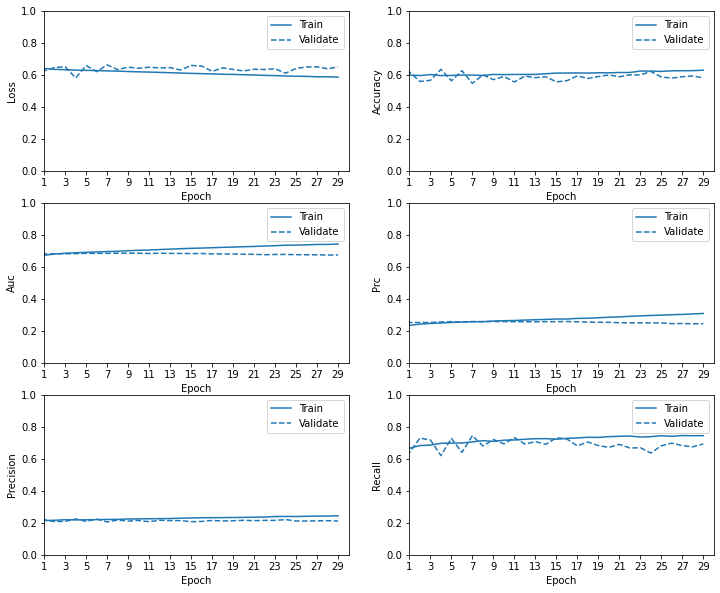

In [43]:
plot_metrics(DNN_history)

In [44]:
# Generating model prediction probabilities
train_predictions = model.predict(train_ds, batch_size=512)
validate_predictions = model.predict(valid_ds, batch_size=512)
test_predictions = model.predict(test_ds, batch_size=512)

123/123 [==============================] - 10s 79ms/step


In [37]:
# Generating model prediction classes
# train_predict_class = np.argmax(train_predictions,axis=1)
# validate_predict_class = np.argmax(validate_predictions,axis=1)
# test_predict_class = np.argmax(test_predictions,axis=1)

In [45]:
# Defining a function to visualize the confusion matrix
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(10,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @ {:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('No Readmission Detected (True Negatives): ', cm[0][0])
  print('Readmission Incorrectly Detected (False Positives): ', cm[0][1])
  print('Readmission Missed (False Negatives): ', cm[1][0])
  print('Readmission Detected (True Positives): ', cm[1][1])

loss :  0.6511606574058533
tp :  6330.0
fp :  23585.0
tn :  30233.0
fn :  2716.0
accuracy :  0.5816206336021423
precision :  0.21159952878952026
recall :  0.6997568011283875
auc :  0.677112340927124
prc :  0.24255433678627014

No Readmission Detected (True Negatives):  30233
Readmission Incorrectly Detected (False Positives):  23585
Readmission Missed (False Negatives):  2716
Readmission Detected (True Positives):  6330


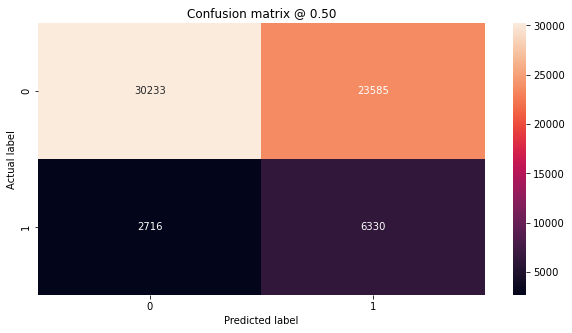

In [46]:
model_results = model.evaluate(test_ds, batch_size=512, verbose=0)
for name, value in zip(model.metrics_names, model_results):
  print(name, ': ', value)
print()
plot_cm(test['Readmit'], test_predictions)

In [47]:
# Defining a function to plot the ROC curve
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100.5])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

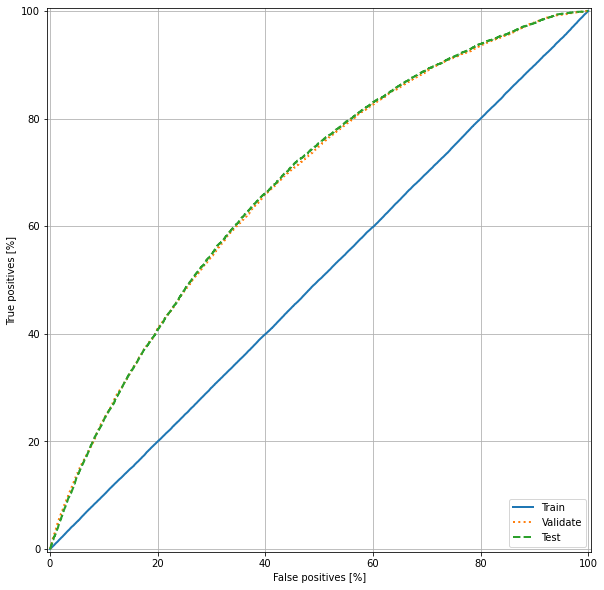

In [48]:
plot_roc("Train", train['Readmit'], train_predictions, color=colors[0], linestyle='solid')
plot_roc("Validate", valid['Readmit'], validate_predictions, color=colors[1], linestyle='dotted')
plot_roc("Test", test['Readmit'], test_predictions, color=colors[2], linestyle='dashed')
plt.legend(loc='lower right');

In [49]:
# Defining a function to plot the AUPRC
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

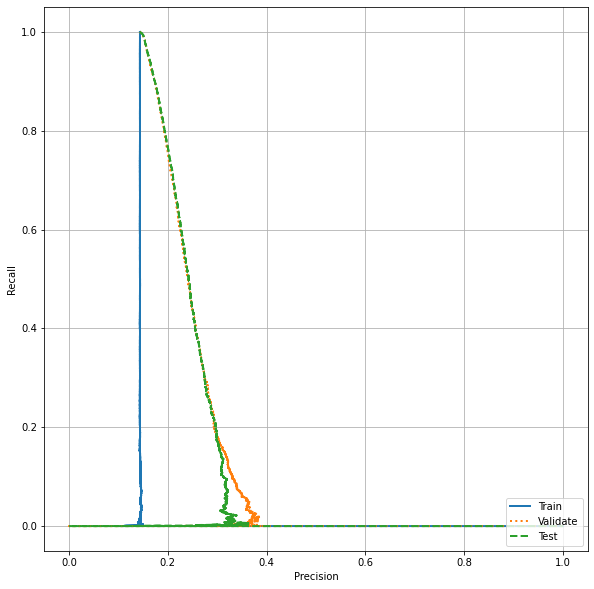

In [50]:
plot_prc("Train", train['Readmit'], train_predictions, color=colors[0], linestyle='solid')
plot_prc("Validate", valid['Readmit'], validate_predictions, color=colors[1], linestyle='dotted')
plot_prc("Test", test['Readmit'], test_predictions, color=colors[2], linestyle='dashed')
plt.legend(loc='lower right');

In [51]:
# Saving the model
model.save('D:\MLE Capstone Project\Model_V3')

INFO:tensorflow:Assets written to: D:\MLE Capstone Project\Model_V3\assets


INFO:tensorflow:Assets written to: D:\MLE Capstone Project\Model_V3\assets
